In [2]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
dataset = pd.read_pickle("/data/.cache/datasets/MAIC2020/x_val.pkl")

In [425]:
row = dataset.iloc[32039].values

In [426]:
signal = row[5:]
signal.shape

(2000,)

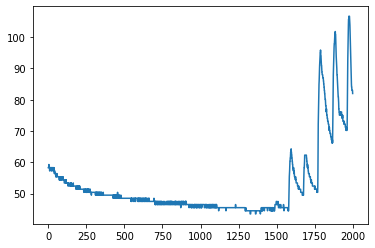

In [427]:
plt.plot(signal)

In [428]:
signal_t = torch.from_numpy(signal.astype("float"))[None, :]
signal_t.shape

torch.Size([1, 2000])

In [429]:
specgram = torchaudio.transforms.Spectrogram()(signal_t)
specgram.shape

torch.Size([1, 201, 11])

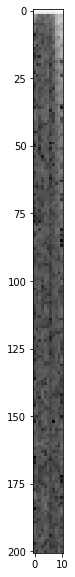

In [430]:
plt.figure(figsize=(7,10))
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='gray')

In [464]:
import torchvision.transforms as F
trans = F.Compose([
    torchaudio.transforms.Spectrogram(n_fft=100),
    torch.log2,
    F.Lambda(lambda x: ((x-x.min())/(x.max()-x.min())).float()),
    F.ToPILImage(),
    F.Grayscale(3),
#     F.Resize((224, 224)),
    F.ToTensor()
])

foo = trans(signal_t)

In [465]:
torchaudio.transforms.Spectrogram()(signal_t).shape

torch.Size([1, 201, 11])

In [461]:
signal_t.shape

torch.Size([1, 2000])

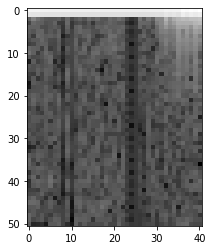

In [466]:
plt.imshow(foo[0], cmap='gray')

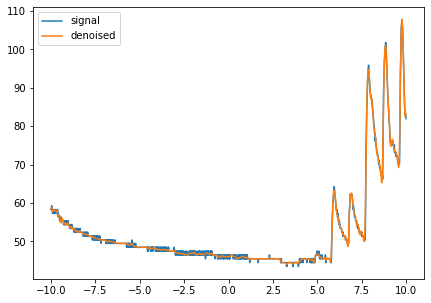

In [434]:
#!/usr/bin/env python3
# −*− coding:utf-8 −*−

import numpy as np
from scipy.linalg import svd


class Denoiser(object):
    '''
    A class for smoothing a noisy, real-valued data sequence by means of SVD of a partial circulant matrix.
    -----
    Attributes:
        mode: str
            Code running mode: "layman" or "expert".
            In the "layman" mode, the code autonomously tries to find the optimal denoised sequence.
            In the "expert" mode, a user has full control over it.
        s: 1D array of floats
            Singular values ordered decreasingly.
        U: 2D array of floats
            A set of left singular vectors as the columns.
        r: int
            Rank of the approximating matrix of the constructed partial circulant matrix from the sequence.
    '''

    def __init__(self, mode="layman"):
        '''
        Class initialization.
        -----
        Arguments:
            mode: str
                Denoising mode. To be selected from ["layman", "expert"]. Default is "layman".
                While "layman" grants the code autonomy, "expert" allows a user to experiment.
        -----
        Raises:
            ValueError
                If mode is neither "layman" nor "expert".
        '''
        self._method = {"layman": self._denoise_for_layman, "expert": self._denoise_for_expert}
        if mode not in self._method:
            raise ValueError("unknown mode '{:s}'!".format(mode))
        self.mode = mode

    def _embed(self, x, m):
        '''
        Embed a 1D array into a 2D partial circulant matrix by cyclic left-shift.
        -----
        Arguments:
            x: 1D array of floats
                Input array.
            m: int
                Number of rows of the constructed matrix.
        -----
        Returns:
            X: 2D array of floats
                Constructed partial circulant matrix.
        '''
        x_ext = np.hstack((x, x[:m-1]))
        shape = (m, x.size)
        strides = (x_ext.strides[0], x_ext.strides[0])
        X = np.lib.stride_tricks.as_strided(x_ext, shape, strides)
        return X

    def _reduce(self, A):
        '''
        Reduce a 2D matrix to a 1D array by cyclic anti-diagonal average.
        -----
        Arguments:
            A: 2D array of floats
                Input matrix.
        -----
        Returns:
            a: 1D array of floats
                Output array.
        '''
        m = A.shape[0]
        A_ext = np.hstack((A[:,-m+1:], A))
        strides = (A_ext.strides[0]-A_ext.strides[1], A_ext.strides[1])
        a = np.mean(np.lib.stride_tricks.as_strided(A_ext[:,m-1:], A.shape, strides), axis=0)
        return a

    def _denoise_for_expert(self, sequence, layer, gap, rank):
        '''
        Smooth a noisy sequence by means of low-rank approximation of its corresponding partial circulant matrix.
        -----
        Arguments:
            sequence: 1D array of floats
                Data sequence to be denoised.
            layer: int
                Number of leading rows selected from the matrix.
            gap: float
                Gap between the data levels on the left and right ends of the sequence.
                A positive value means the right level is higher.
            rank: int
                Rank of the approximating matrix.
        -----
        Returns:
            denoised: 1D array of floats
                Smoothed sequence after denoise.
        -----
        Raises:
            AssertionError
                If condition 1 <= rank <= layer <= sequence.size cannot be fulfilled.
        '''
        assert 1 <= rank <= layer <= sequence.size
        self.r = rank
        # linear trend to be deducted
        trend = np.linspace(0, gap, sequence.size)
        X = self._embed(sequence-trend, layer)
        # singular value decomposition
        self.U, self.s, Vh = svd(X, full_matrices=False, overwrite_a=True, check_finite=False)
        # low-rank approximation
        A = self.U[:,:self.r] @ np.diag(self.s[:self.r]) @ Vh[:self.r]
        denoised = self._reduce(A) + trend
        return denoised

    def _cross_validate(self, x, m):
        '''
        Check if the gap of boundary levels of the detrended sequence is within the estimated noise strength.
        -----
        Arguments:
            x: 1D array of floats
                Input array.
            m: int
                Number of rows of the constructed matrix.
        -----
        Returns:
            valid: bool
                Result of cross validation. True means the detrending procedure is valid.
        '''
        X = self._embed(x, m)
        self.U, self.s, self._Vh = svd(X, full_matrices=False, overwrite_a=True, check_finite=False)
        # Search for noise components using the normalized mean total variation of the left singular vectors as an indicator.
        # The procedure runs in batch of every 10 singular vectors.
        self.r = 0
        while True:
            U_sub = self.U[:,self.r:self.r+10]
            NMTV = np.mean(np.abs(np.diff(U_sub,axis=0)), axis=0) / (np.amax(U_sub,axis=0) - np.amin(U_sub,axis=0))
            try:
                # the threshold of 10% can in most cases discriminate noise components
                self.r += np.argwhere(NMTV > .1)[0,0]
                break
            except IndexError:
                self.r += 10
        # estimate the noise strength, while r marks the first noise component
        noise_stdev = np.sqrt(np.sum(self.s[self.r:]**2) / X.size)
        # estimate the gap of boundary levels after detrend
        gap = np.abs(x[-self._k:].mean()-x[:self._k].mean())
        valid = gap < noise_stdev
        return valid

    def _denoise_for_layman(self, sequence, layer):
        '''
        Similar to the "expert" method, except that denoising parameters are optimized autonomously.
        -----
        Arguments:
            sequence: 1D array of floats
                Data sequence to be denoised.
            layer: int
                Number of leading rows selected from the corresponding circulant matrix.
        -----
        Returns:
            denoised: 1D array of floats
                Smoothed sequence after denoise.
        -----
        Raises:
            AssertionError
                If condition 1 <= layer <= sequence.size cannot be fulfilled.
        '''
        assert 1 <= layer <= sequence.size
        # The code takes the mean of a few neighboring data to estimate the boundary levels of the sequence.
        # By default, this number is 11.
        self._k = 11
        # Initially, the code assumes no linear inclination.
        trend = np.zeros_like(sequence)
        # Iterate over the averaging length.
        # In the worst case, iteration must terminate when it is 1.
        while not self._cross_validate(sequence-trend, layer):
            self._k -= 2
            trend = np.linspace(0, sequence[-self._k:].mean()-sequence[:self._k].mean(), sequence.size)
        # low-rank approximation by using only signal components
        A = self.U[:,:self.r] @ np.diag(self.s[:self.r]) @ self._Vh[:self.r]
        denoised = self._reduce(A) + trend
        return denoised

    def denoise(self, *args, **kwargs):
        '''
        User interface method.
        It will reference to different denoising methods ad hoc under the fixed name.
        '''
        return self._method[self.mode](*args, **kwargs)


if __name__ == "__main__":
    x = np.linspace(-10, 10, 2000)
#     signal = np.sinc(x)
#     noise = np.random.normal(scale=.1, size=1000)
#     sequence = signal + noise
    denoiser = Denoiser()
    denoised = denoiser.denoise(signal.astype(np.float), 300)
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(7,5))
    ax.plot(x, signal, label='signal')
    ax.plot(x, denoised, label='denoised')
    ax.legend()
    plt.show()

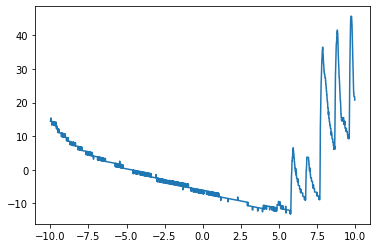

In [435]:
import scipy
plt.plot(x, scipy.signal.detrend(signal))

In [406]:
signal.shape

(2000,)

In [438]:
y_true = pd.read_pickle("/data/.cache/datasets/MAIC2020/y_val.pkl")

In [450]:
np.unique(y_true["class"].values, return_counts=True)

(array([0, 1]), array([177662,   9373]))